In [789]:
import jax
from jax import numpy as jnp
import numpy as np
import utils
import copy, time
import matplotlib
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

plt.rcParams['font.family'] = 'STIXGeneral'  # Closely matches Computer Modern
plt.rcParams['mathtext.fontset'] = 'stix'    # Use STIX for math

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Binary and timing properties [default]

In [830]:
pars = dict(
    cw_costheta=0.0,
    cw_phi=0.0,
    cw_cosinc=0.99,
    cw_log10_Mc=9.5,
    cw_log10_fgw=-8.,
    cw_log10_dist=2.385,
    cw_phase0=0.,
    cw_psi=0.,
)

# Define 100 TOAs over 10 years at 10 per year, with 100 ns errors
t0 = 58000.0 * 86400.0
t1 = t0 + 10.0 * 365.25 * 86400.0
toas_new = jnp.linspace(t0, t1, 100)
toaerrs = jnp.full_like(toas_new, 1e-6)

### Exploring angular resolution by pulsar proximity

In [791]:
psrs_ring = utils.pulsar_ring_generator(pars=pars, ang_radius=40.0, npsrs=20, toas=toas_new, toaerrs=toaerrs)

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:49: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)
/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:50: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.pdist = jnp.array(pdist)


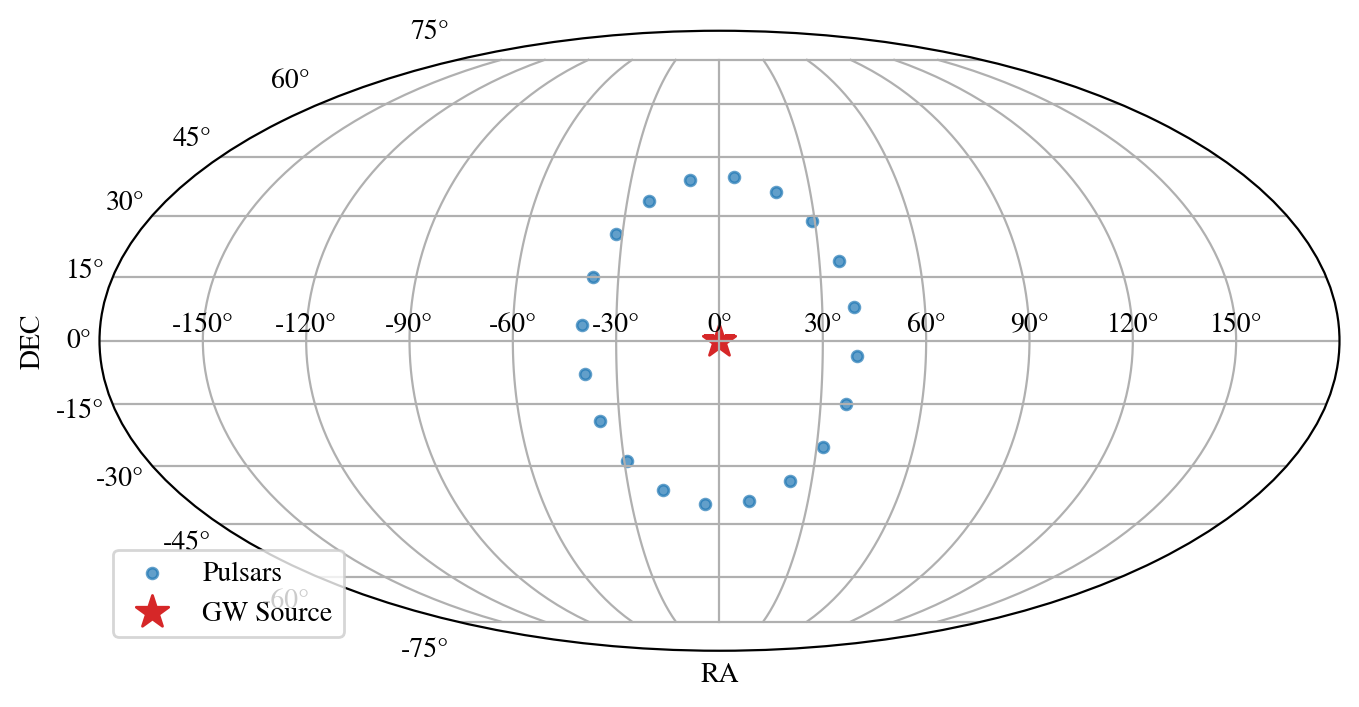

In [792]:
ra_ring = jnp.array([p.ra for p in psrs_ring])
dec_ring = jnp.array([p.dec for p in psrs_ring])
# Mollweide projection of pulsar sky locations and GW source
# wrap RA into [-π, +π] for plotting
ra_wrap = (ra_ring + jnp.pi) % (2 * jnp.pi) - jnp.pi

# GW source sky coords from pars
gw_dec = jnp.arcsin(pars['cw_costheta'])
gw_ra  = (pars['cw_phi'] + jnp.pi) % (2 * jnp.pi) - jnp.pi

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(projection='mollweide')
ax.scatter(ra_wrap, dec_ring, s=15, color='C0', alpha=0.7, label='Pulsars')
ax.scatter(gw_ra,   gw_dec, s=150, color='C3', marker='*', label='GW Source')
ax.grid(True)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.legend(loc='lower left')
#plt.title('Mollweide Projection of Pulsar Sky & GW Origin')
plt.show()

In [793]:
# Instantiate a CW_Signal for each pulsar in the psrs list
cw_signals = [
    utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
    for p in psrs_ring
]

# deep-copy the dictionary so nested objects are also copied
pars_copy = copy.deepcopy(pars)
total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
pars_copy['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 5.0)

# list of fisher matrices, one per pulsar
fishers = [utils.compute_fisher(cw,pars_copy) for cw in cw_signals]
total_fisher = jnp.sum(jnp.stack(fishers), axis=0)

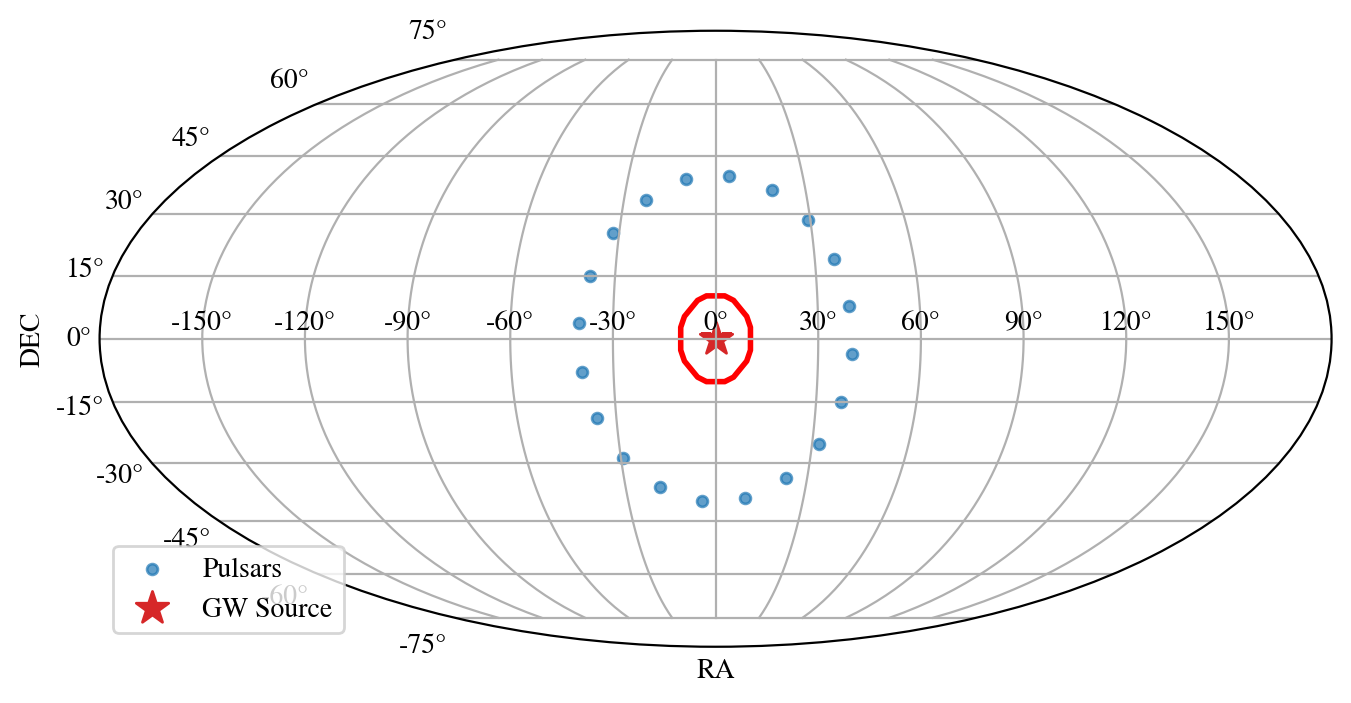

In [794]:
# Center in degrees (lon, lat)
center_uphi = (pars['cw_costheta'], pars['cw_phi'])

fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111, projection='mollweide')
utils.plot_fisher_ellipse_on_sky(total_fisher[:2,:2], center_uphi, ax=ax,
                                edgecolor='red', facecolor='none', lw=2)
ax.scatter(ra_wrap, dec_ring, s=15, color='C0', alpha=0.7, label='Pulsars')
ax.scatter(gw_ra,   gw_dec, s=150, color='C3', marker='*', label='GW Source')
ax.grid(True)
ax.set_xlabel('RA')
ax.set_ylabel('DEC')
ax.legend(loc='lower left')
#plt.title('Mollweide Projection of Pulsar Sky & GW Origin')
plt.show()

### Fixed SNR=10 and fixed number of pulsars = 20

In [25]:
angles = jnp.linspace(0.1,179.9,100)
omega_sky_fSNR_npsr20 = []
omega_sky_fSNR_npsr20_marg = []
snr_fixparams = []
for ang in angles:
    psrs_ring = utils.pulsar_ring_generator(pars=pars, ang_radius=ang, npsrs=20, 
                                            toas=toas_new, toaerrs=toaerrs)
    # Instantiate a CW_Signal for each pulsar in the psrs list
    cw_signals = [
        utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
        for p in psrs_ring
                 ]
    
    # deep-copy the dictionary so nested objects are also copied
    pars_copy = copy.deepcopy(pars)
    total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    snr_fixparams.append(total_snr)
    
    pars_copy['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 10.)
    # list of fisher matrices, one per pulsar
    fishers = [utils.compute_fisher(cw,pars_copy) for cw in cw_signals]
    total_fisher = jnp.sum(jnp.stack(fishers), axis=0)
    
    #modified_snr = jnp.sum(jnp.stack([computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    #print(total_snr, modified_snr)
    #omega_sky.append( (180/jnp.pi)**2 * 2.0*jnp.pi/jnp.linalg.det(total_fisher[:2,:2])**0.5 )

    fisher_inv = jnp.linalg.pinv(total_fisher)[:2,:2]
    omega_sky_fSNR_npsr20.append( (180/jnp.pi)**2 * 2.0*jnp.pi / jnp.linalg.det(total_fisher[:2,:2])**0.5 )
    omega_sky_fSNR_npsr20_marg.append( (180/jnp.pi)**2 * 2.0*jnp.pi * jnp.linalg.det(fisher_inv)**0.5 )

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:49: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)
/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:50: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.pdist = jnp.array(pdist)


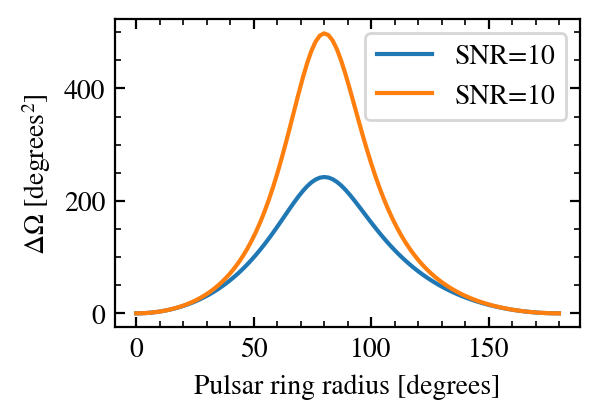

In [795]:
plt.plot(angles, jnp.array(omega_sky_fSNR_npsr20), label='SNR=10');
plt.plot(angles, jnp.array(omega_sky_fSNR_npsr20_marg), label='SNR=10');
#plt.plot(angles, jnp.array(omega_sky_cosinc0), label='SNR=10');
#plt.plot(angles, omega_sky, label='SNR=10');
#plt.plot(angles, 0.05*jnp.array(angles)**2.0, label='$\propto \\theta_\mathrm{sep}^2$')
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Pulsar ring radius [degrees]')
plt.ylabel('$\Delta\Omega$ [degrees$^2$]')
plt.minorticks_on()
plt.tick_params(which='both',tick2On=True,direction='in')
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3, 2)

plt.show()

/var/folders/k2/_9gds9k559z0m9h0s7g0zlkc0000gn/T/ipykernel_1354/1835457705.py:9: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


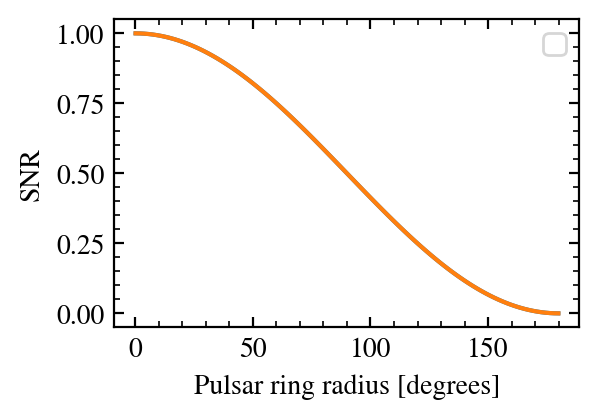

In [796]:
plt.plot(angles, jnp.array(snr_fixparams)/jnp.array(snr_fixparams).max());
plt.plot(angles, 0.5*(1.0+jnp.cos(jnp.radians(angles))));
#plt.xscale('log')
#plt.yscale('log')
plt.xlabel('Pulsar ring radius [degrees]')
plt.ylabel('SNR')
plt.minorticks_on()
plt.tick_params(which='both',tick2On=True,direction='in')
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3, 2)

plt.show()

### Fixed SNR=10; keep pulsars in ring at North Pole; move source around sky

In [ ]:
!pip install healpy

In [147]:
import healpy as hp

# set up a Healpix grid
nside = 16
npix = hp.nside2npix(nside)
print(npix)
pix_idx = jnp.arange(npix)

# get the pixel center in colatitude (θ) and longitude (φ), in radians
theta_np, phi_np = hp.pix2ang(nside, np.arange(npix))
theta_hp = jnp.array(theta_np)
phi_hp = jnp.array(phi_np)

# convert to declination and right-ascension
dec_hp = 0.5 * jnp.pi - theta_hp  # DEC = π/2 – θ
ra_hp = phi_hp                    # RA = φ

# ra_hp, dec_hp now hold the sky locations for each pixel
#ra_hp, dec_hp

3072


In [138]:
pars_map = dict(
    cw_costheta=0.999,
    cw_phi=0.0,
    cw_cosinc=0.99,
    cw_log10_Mc=9.5,
    cw_log10_fgw=-8.,
    cw_log10_dist=2.385,
    cw_phase0=0.,
    cw_psi=0.,
)

In [ ]:
omega_sky_fSNR_map_npsr20 = []
omega_sky_fSNR_map_npsr20_marg = []
snr_fixparams_map = []
for jj in pix_idx:
    psrs_ring = utils.pulsar_ring_generator(pars=pars_map, ang_radius=10.0, npsrs=20, 
                                            toas=toas_new, toaerrs=toaerrs)
    # Instantiate a CW_Signal for each pulsar in the psrs list
    cw_signals = [
        utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
        for p in psrs_ring
                 ]
    
    # deep-copy the dictionary so nested objects are also copied
    pars_copy = copy.deepcopy(pars_map)
    # set the GW source sky location from the Healpix pixel
    pars_copy['cw_costheta'] = jnp.cos(theta_hp[jj])
    pars_copy['cw_phi']      = phi_hp[jj]
    total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    snr_fixparams_map.append(total_snr)

    pars_copy['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 10.)
    # list of fisher matrices, one per pulsar
    fishers = [utils.compute_fisher(cw,pars_copy) for cw in cw_signals]
    total_fisher = jnp.sum(jnp.stack(fishers), axis=0)
    
    #modified_snr = jnp.sum(jnp.stack([computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    #print(total_snr, modified_snr)
    #omega_sky.append( (180/jnp.pi)**2 * 2.0*jnp.pi/jnp.linalg.det(total_fisher[:2,:2])**0.5 )

    fisher_inv = jnp.linalg.pinv(total_fisher)[:2,:2]
    omega_sky_fSNR_map_npsr20.append( (180/jnp.pi)**2 * 2.0*jnp.pi / jnp.linalg.det(total_fisher[:2,:2])**0.5 )
    omega_sky_fSNR_map_npsr20_marg.append( (180/jnp.pi)**2 * 2.0*jnp.pi * jnp.linalg.det(fisher_inv)**0.5 )

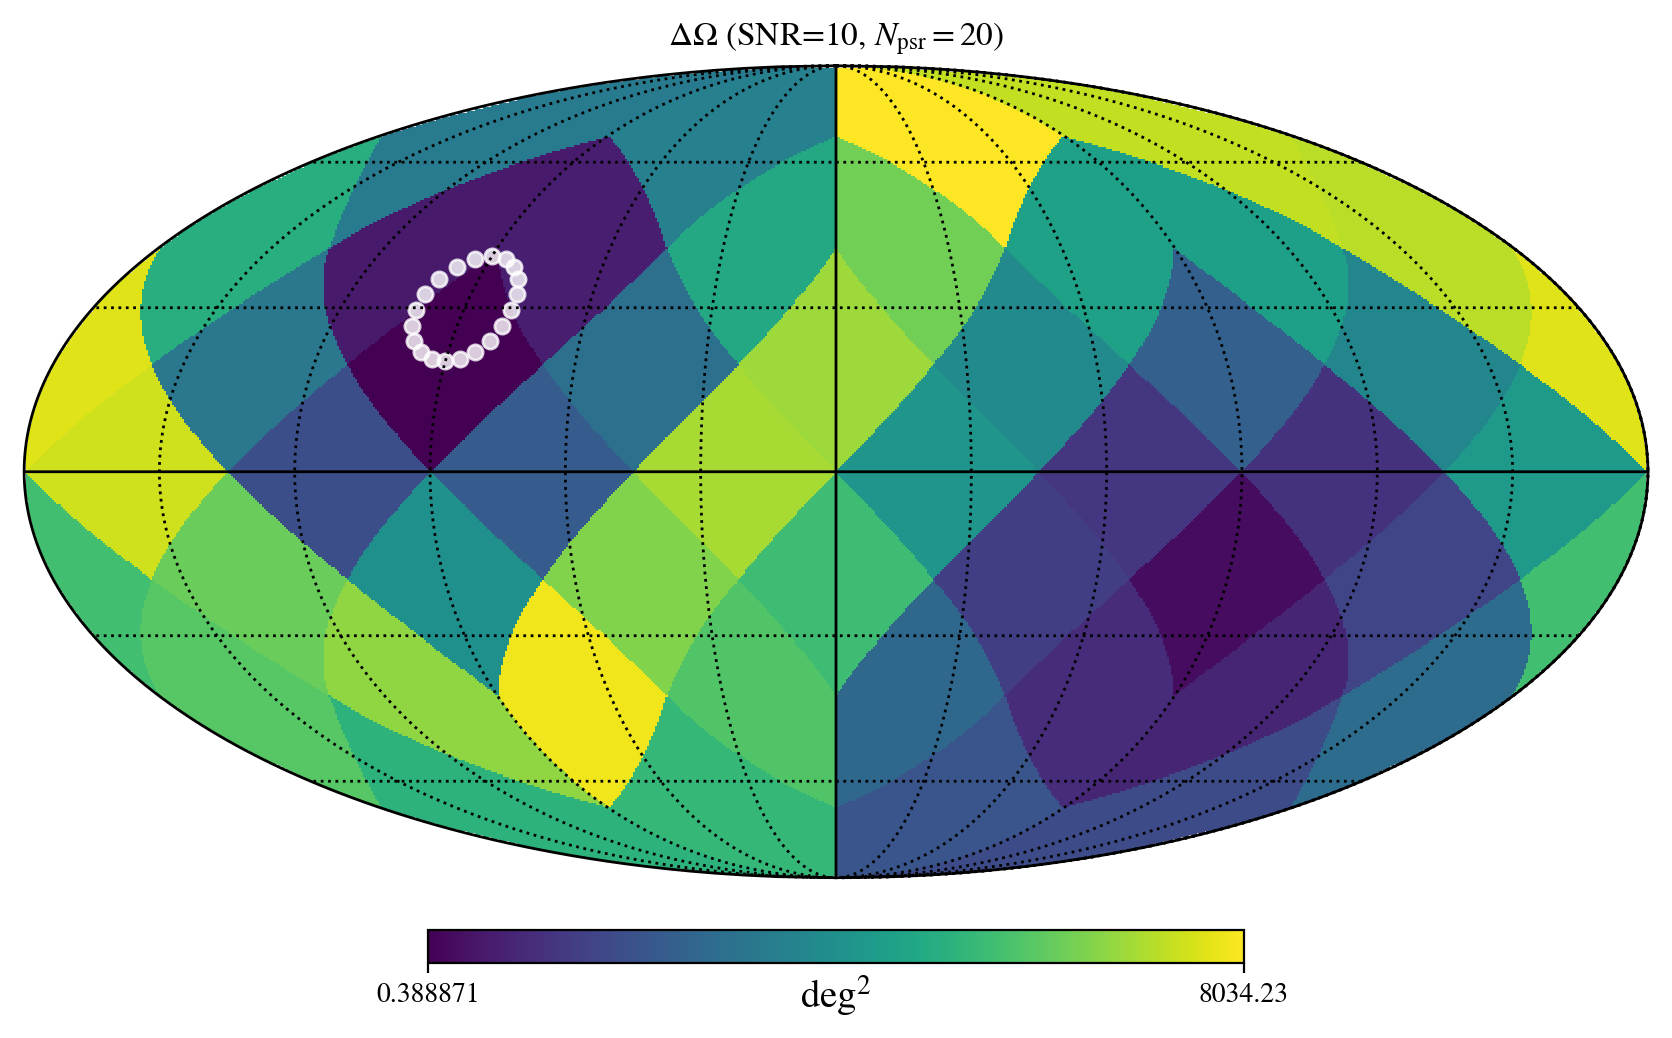

In [ ]:
# Create a Healpix map of the localization area and display it
omega_map = np.array(omega_sky_fSNR_map_npsr20)

# Plot with a Mollweide projection
hp.mollview(omega_map,
            title=r'$\Delta\Omega$ (SNR=10, $N_{\rm psr}=20$)',
            unit='deg$^2$',
            cmap='viridis',
            norm='hist')
# overlay pulsar positions from the last psrs_ring
ras = np.degrees(np.array([p.ra for p in psrs_ring]))
decs = np.degrees(np.array([p.dec for p in psrs_ring]))
hp.projscatter(ras, decs, lonlat=True, s=30, color='white', marker='o', alpha=0.8)
hp.graticule()
plt.show()

#### Now make it faster

##### Fixed SNR

In [798]:
from functools import partial

# 1) write a pure “per‐pixel” function
@partial(jax.jit, static_argnames=('npsrs','ang_radius'))
def _compute_pixel(theta, phi,
                   pars_base,
                   toas, toaerrs,
                   npsrs=20, ang_radius=10.0):
    # generate ring of pulsars (this must itself be jittable!)
    psrs = utils.pulsar_ring_generator(
        pars=pars_base,
        ang_radius=ang_radius,
        npsrs=npsrs,
        toas=toas,
        toaerrs=toaerrs,
    )

    # instantiate CW_Signals
    cws = [utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
           for p in psrs]

    # update sky location
    pars = pars_base.copy()
    pars['cw_costheta'] = jnp.cos(theta)
    pars['cw_phi']      = phi

    # total SNR
    snr2 = jnp.stack([utils.computer_snr2(cw, pars) for cw in cws])
    total_snr = jnp.sqrt(jnp.sum(snr2, axis=0))

    # renormalize distance
    pars['cw_log10_dist'] = jnp.log10(
        total_snr * 10**pars_base['cw_log10_dist'] / 10.0
    )

    # Fisher matrix sum
    fishers = jnp.stack([utils.compute_fisher(cw, pars) for cw in cws])
    F = jnp.sum(fishers, axis=0)

    # unmarginalized & marginalized areas
    ω = (180/jnp.pi)**2 * 2*jnp.pi / jnp.linalg.det(F[:2,:2])**0.5
    Finv = jnp.linalg.pinv(F)
    ω_marg = (180/jnp.pi)**2 * 2*jnp.pi * jnp.linalg.det(Finv[:2,:2])**0.5

    return total_snr, ω, ω_marg

# 2) vmap it over your Healpix arrays
snr_map, omega_map, omega_marg_map = jax.vmap(
    partial(_compute_pixel,
            pars_base=pars_map,
            toas=toas_new,
            toaerrs=toaerrs,
            npsrs=20,
            ang_radius=10.0),
    in_axes=(0,0)
)(theta_hp, phi_hp)

# now snr_map, omega_map, omega_marg_map are jax arrays of length npix

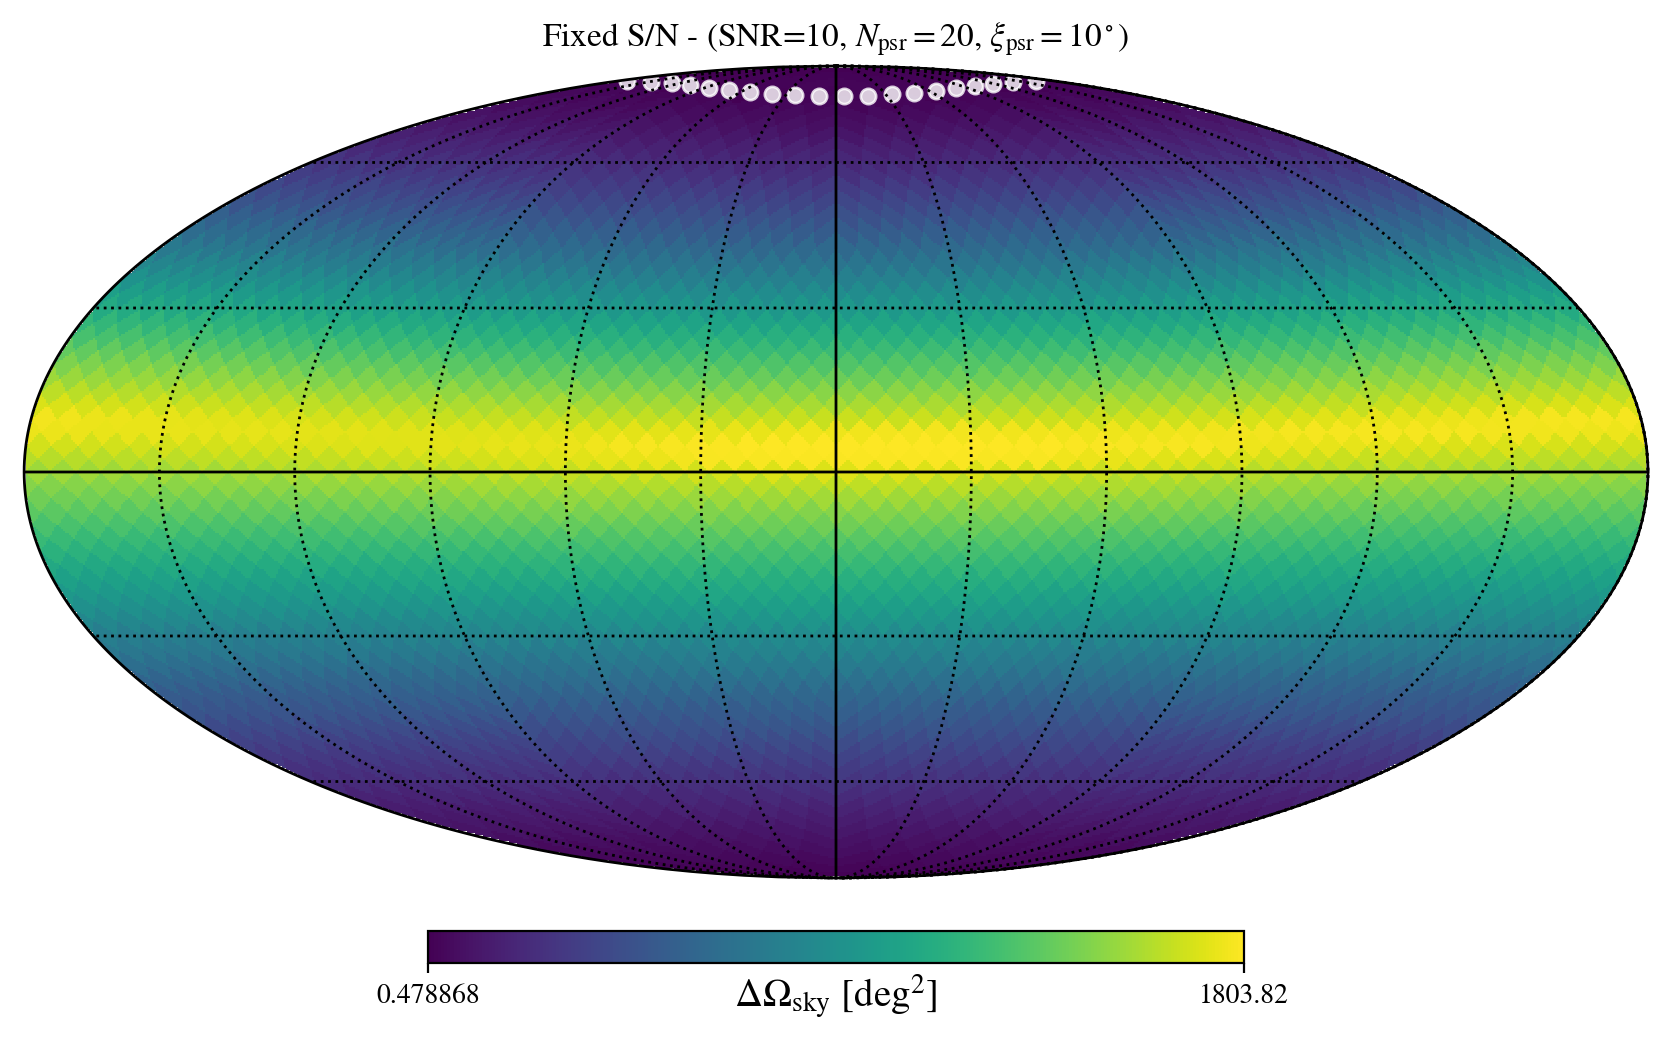

In [799]:
# Plot with a Mollweide projection
hp.mollview(omega_map,
            #title=r'Fixed binary parameters - ($N_{\rm psr}=20$, $\xi_{\rm psr}=10^\circ)$',
            title=r'Fixed S/N - (SNR=10, $N_{\rm psr}=20$, $\xi_{\rm psr}=10^\circ)$',
            unit='$\Delta\Omega_{\\rm sky}$ [deg$^2$]',
            cmap='viridis',
            norm='hist')
# overlay pulsar positions from the last psrs_ring
# generate ring of pulsars (this must itself be jittable!)
psrs_ring = utils.pulsar_ring_generator(pars=pars_map, ang_radius=10.0, npsrs=20, 
                                        toas=toas_new, toaerrs=toaerrs)
ras = np.degrees(np.array([p.ra for p in psrs_ring]))
decs = np.degrees(np.array([p.dec for p in psrs_ring]))
hp.projscatter(ras, decs, lonlat=True, s=30, color='white', marker='o', alpha=0.8)
hp.graticule()
plt.show()

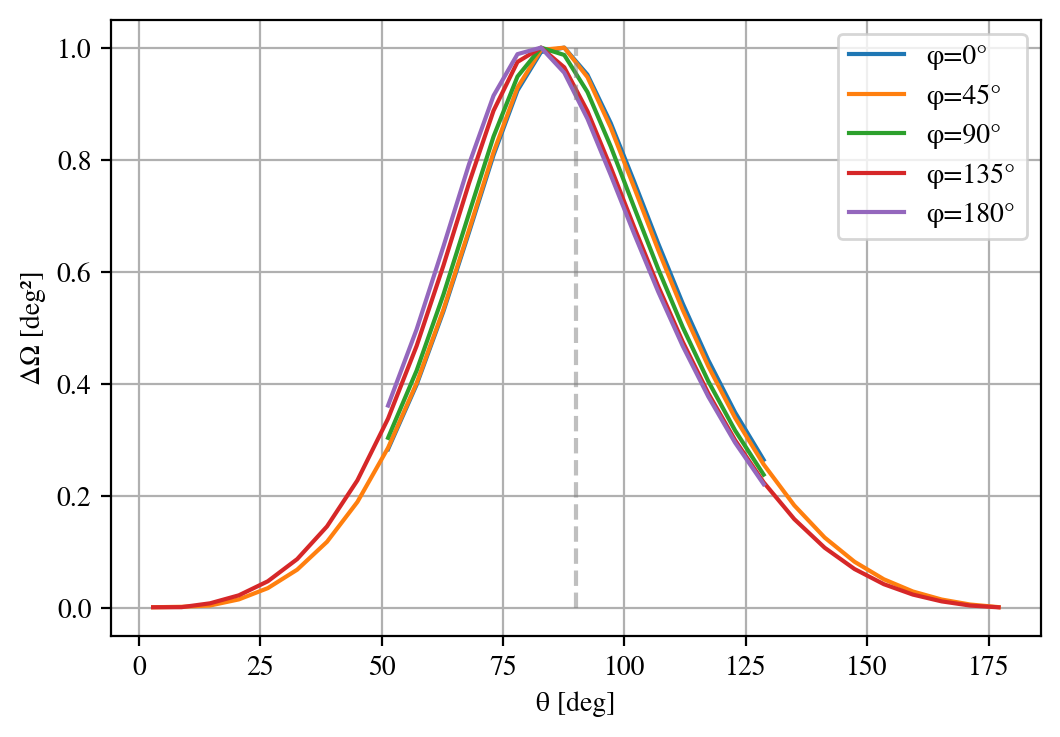

In [800]:
# Slice the healpix localization map ω(θ,φ) at several fixed φ values
phi_slices = [0.0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]   # in radians
tol = np.deg2rad(1.0)                                    # tolerance ~1°

# Convert JAX arrays to NumPy
phi_arr   = np.array(phi_hp)
theta_arr = np.array(theta_hp)
omega_arr = np.array(omega_map)

plt.figure(figsize=(6,4))
for phi_val in phi_slices:
    # compute wrapped difference into [-π, +π]
    dphi = (phi_arr - phi_val + np.pi) % (2*np.pi) - np.pi
    mask = np.abs(dphi) < tol
    th = theta_arr[mask]
    om = omega_arr[mask]
    # sort by θ for a clean line
    idx = np.argsort(th)
    plt.plot(np.degrees(th[idx]), om[idx]/om[idx].max(), label=f"φ={np.degrees(phi_val):.0f}°")

plt.vlines(90.0, 0, 1, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('θ [deg]')
plt.ylabel('ΔΩ [deg²]')
plt.legend()
plt.grid(True)
plt.show()

##### Fixed binary parameters

In [807]:
from functools import partial

# 1) write a pure “per‐pixel” function
@partial(jax.jit, static_argnames=('npsrs','ang_radius'))
def _compute_pixel(theta, phi,
                   pars_base,
                   toas, toaerrs,
                   npsrs=20, ang_radius=10.0):
    # generate ring of pulsars (this must itself be jittable!)
    psrs = utils.pulsar_ring_generator(
        pars=pars_base,
        ang_radius=ang_radius,
        npsrs=npsrs,
        toas=toas,
        toaerrs=toaerrs,
    )

    # instantiate CW_Signals
    cws = [utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
           for p in psrs]

    # update sky location
    pars = pars_base.copy()
    pars['cw_costheta'] = jnp.cos(theta)
    pars['cw_phi']      = phi

    # total SNR
    snr2 = jnp.stack([utils.computer_snr2(cw, pars) for cw in cws])
    total_snr = jnp.sqrt(jnp.sum(snr2, axis=0))

    # renormalize distance
    #pars['cw_log10_dist'] = jnp.log10(
    #    total_snr * 10**pars_base['cw_log10_dist'] / 10.0
    #)

    # Fisher matrix sum
    fishers = jnp.stack([utils.compute_fisher(cw, pars) for cw in cws])
    F = jnp.sum(fishers, axis=0)

    # unmarginalized & marginalized areas
    ω = (180/jnp.pi)**2 * 2*jnp.pi / jnp.linalg.det(F[:2,:2])**0.5
    Finv = jnp.linalg.pinv(F)
    ω_marg = (180/jnp.pi)**2 * 2*jnp.pi * jnp.linalg.det(Finv[:2,:2])**0.5

    return total_snr, ω, ω_marg

# 2) vmap it over your Healpix arrays
snr_map, omega_map, omega_marg_map = jax.vmap(
    partial(_compute_pixel,
            pars_base=pars_map,
            toas=toas_new,
            toaerrs=toaerrs,
            npsrs=20,
            ang_radius=5.0),
    in_axes=(0,0)
)(theta_hp, phi_hp)

# now snr_map, omega_map, omega_marg_map are jax arrays of length npix

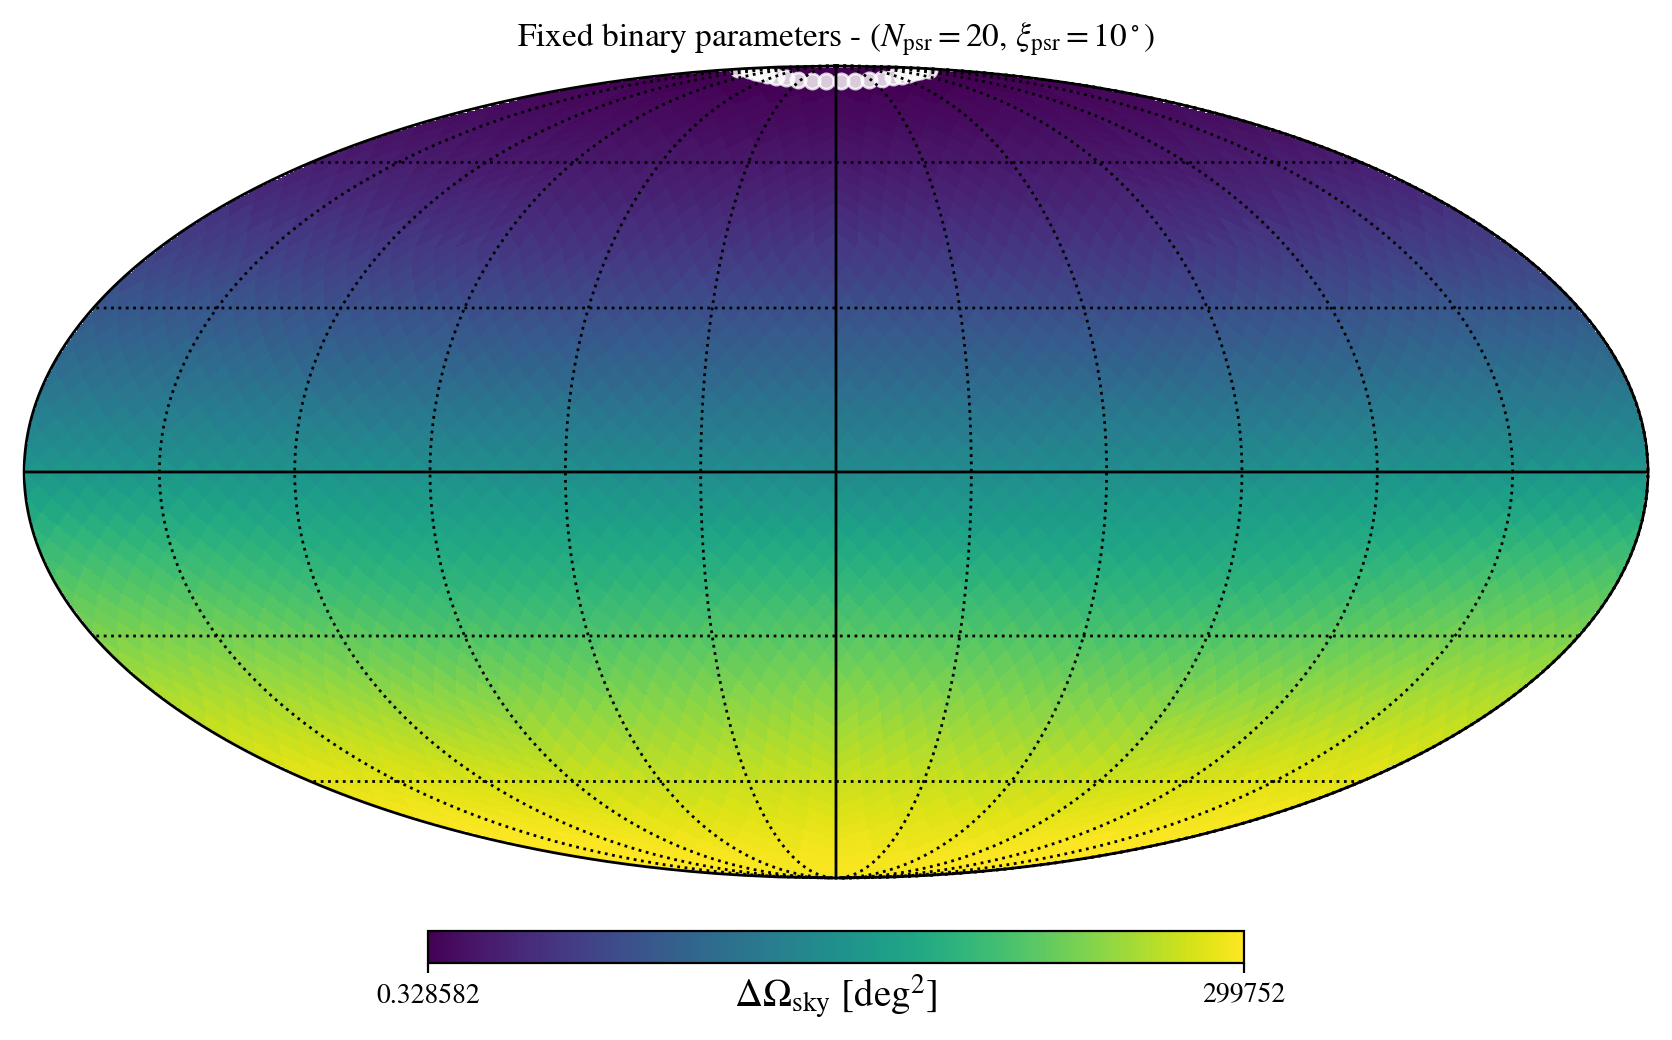

In [808]:
# Plot with a Mollweide projection
hp.mollview(omega_map,
            title=r'Fixed binary parameters - ($N_{\rm psr}=20$, $\xi_{\rm psr}=10^\circ)$',
            #title=r'Fixed S/N - (SNR=10, $N_{\rm psr}=20$, $\xi_{\rm psr}=10^\circ)$',
            unit='$\Delta\Omega_{\\rm sky}$ [deg$^2$]',
            cmap='viridis',
            norm='hist')
# overlay pulsar positions from the last psrs_ring
# generate ring of pulsars (this must itself be jittable!)
psrs_ring = utils.pulsar_ring_generator(pars=pars_map, ang_radius=5.0, npsrs=20, 
                                        toas=toas_new, toaerrs=toaerrs)
ras = np.degrees(np.array([p.ra for p in psrs_ring]))
decs = np.degrees(np.array([p.dec for p in psrs_ring]))
hp.projscatter(ras, decs, lonlat=True, s=30, color='white', marker='o', alpha=0.8)
hp.graticule()
plt.show()

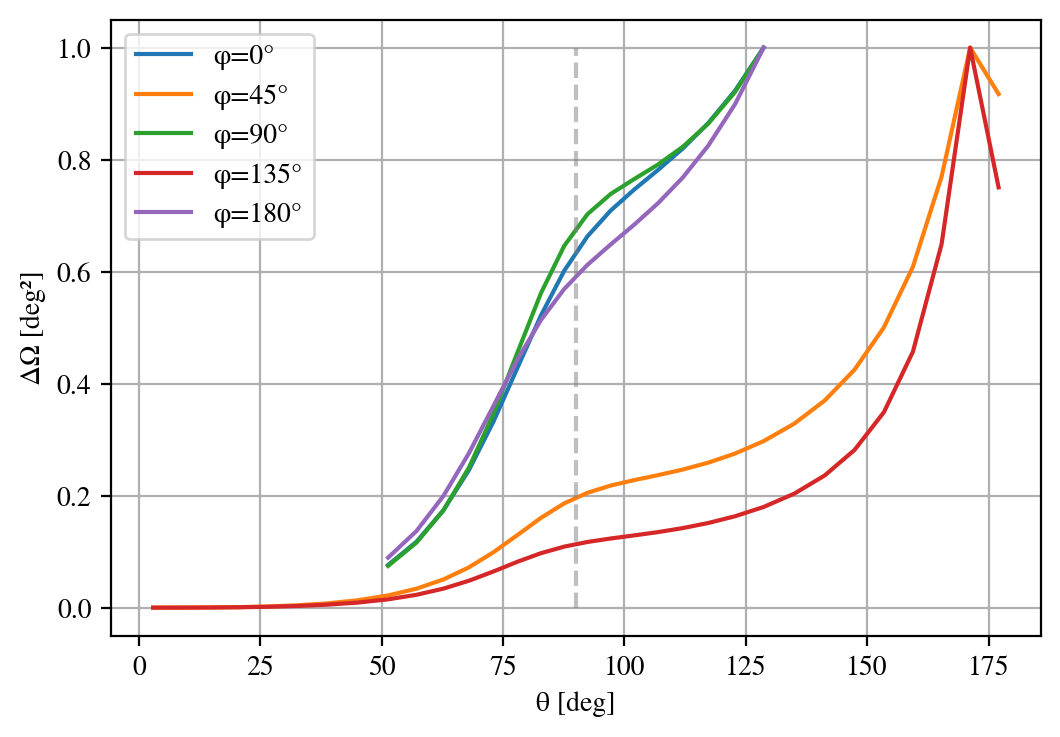

In [809]:
# Slice the healpix localization map ω(θ,φ) at several fixed φ values
phi_slices = [0.0, np.pi/4, np.pi/2, 3*np.pi/4, np.pi]   # in radians
tol = np.deg2rad(1.0)                                    # tolerance ~1°

# Convert JAX arrays to NumPy
phi_arr   = np.array(phi_hp)
theta_arr = np.array(theta_hp)
omega_arr = np.array(omega_map)

plt.figure(figsize=(6,4))
for phi_val in phi_slices:
    # compute wrapped difference into [-π, +π]
    dphi = (phi_arr - phi_val + np.pi) % (2*np.pi) - np.pi
    mask = np.abs(dphi) < tol
    th = theta_arr[mask]
    om = omega_arr[mask]
    # sort by θ for a clean line
    idx = np.argsort(th)
    plt.plot(np.degrees(th[idx]), om[idx]/om[idx].max(), label=f"φ={np.degrees(phi_val):.0f}°")

plt.vlines(90.0, 0, 1, color='gray', linestyle='--', alpha=0.5)
plt.xlabel('θ [deg]')
plt.ylabel('ΔΩ [deg²]')
plt.legend()
plt.grid(True)
plt.show()

### Random annulus of pulsars

In [ ]:
angles = jnp.linspace(0.1,179.9,10)
omega_sky_ann_fSNR_npsr20 = []
omega_sky_ann_fSNR_npsr20_marg = []
snr_fixparams = []
for idx, ang in enumerate(angles):
    # per-iteration seed from high‑res clock + loop index (avoid accidental duplicates)
    seed = (time.time_ns() + idx) & 0xffffffff
    key = jax.random.PRNGKey(seed)

    psrs_ann = utils.pulsar_annulus_generator(pars=pars, inner_ang_radius=ang, width_deg=1.0,
                                               npsrs=20, toas=toas_new, toaerrs=toaerrs, key=key)
    # Instantiate a CW_Signal for each pulsar in the psrs list
    cw_signals = [
        utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
        for p in psrs_ann
                 ]
    
    # deep-copy the dictionary so nested objects are also copied
    pars_copy = copy.deepcopy(pars)
    total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    snr_fixparams.append(total_snr)
    
    pars_copy['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 10.)
    # list of fisher matrices, one per pulsar
    fishers = [utils.compute_fisher(cw,pars_copy) for cw in cw_signals]
    total_fisher = jnp.sum(jnp.stack(fishers), axis=0)
    
    #modified_snr = jnp.sum(jnp.stack([computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    #print(total_snr, modified_snr)
    #omega_sky.append( (180/jnp.pi)**2 * 2.0*jnp.pi/jnp.linalg.det(total_fisher[:2,:2])**0.5 )

    fisher_inv = jnp.linalg.pinv(total_fisher)[:2,:2]
    omega_sky_ann_fSNR_npsr20.append( (180/jnp.pi)**2 * 2.0*jnp.pi / jnp.linalg.det(total_fisher[:2,:2])**0.5 )
    omega_sky_ann_fSNR_npsr20_marg.append( (180/jnp.pi)**2 * 2.0*jnp.pi * jnp.linalg.det(fisher_inv)**0.5 )

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:49: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)
/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:50: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.pdist = jnp.array(pdist)


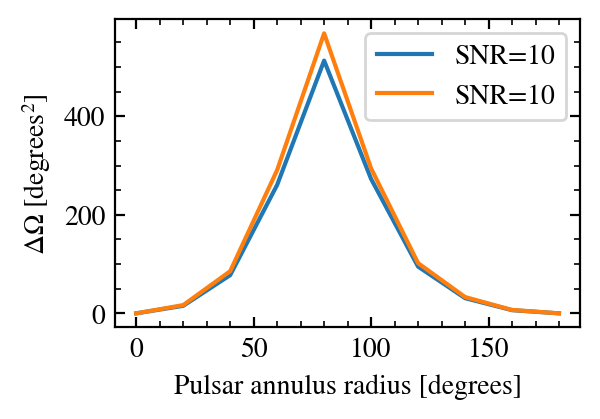

In [832]:
plt.plot(angles, jnp.array(omega_sky_ann_fSNR_npsr20), label='SNR=10');
plt.plot(angles, jnp.array(omega_sky_ann_fSNR_npsr20_marg), label='SNR=10');

plt.xlabel('Pulsar annulus radius [degrees]')
plt.ylabel('$\Delta\Omega$ [degrees$^2$]')
plt.minorticks_on()
plt.tick_params(which='both',tick2On=True,direction='in')
plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3, 2)

plt.show()

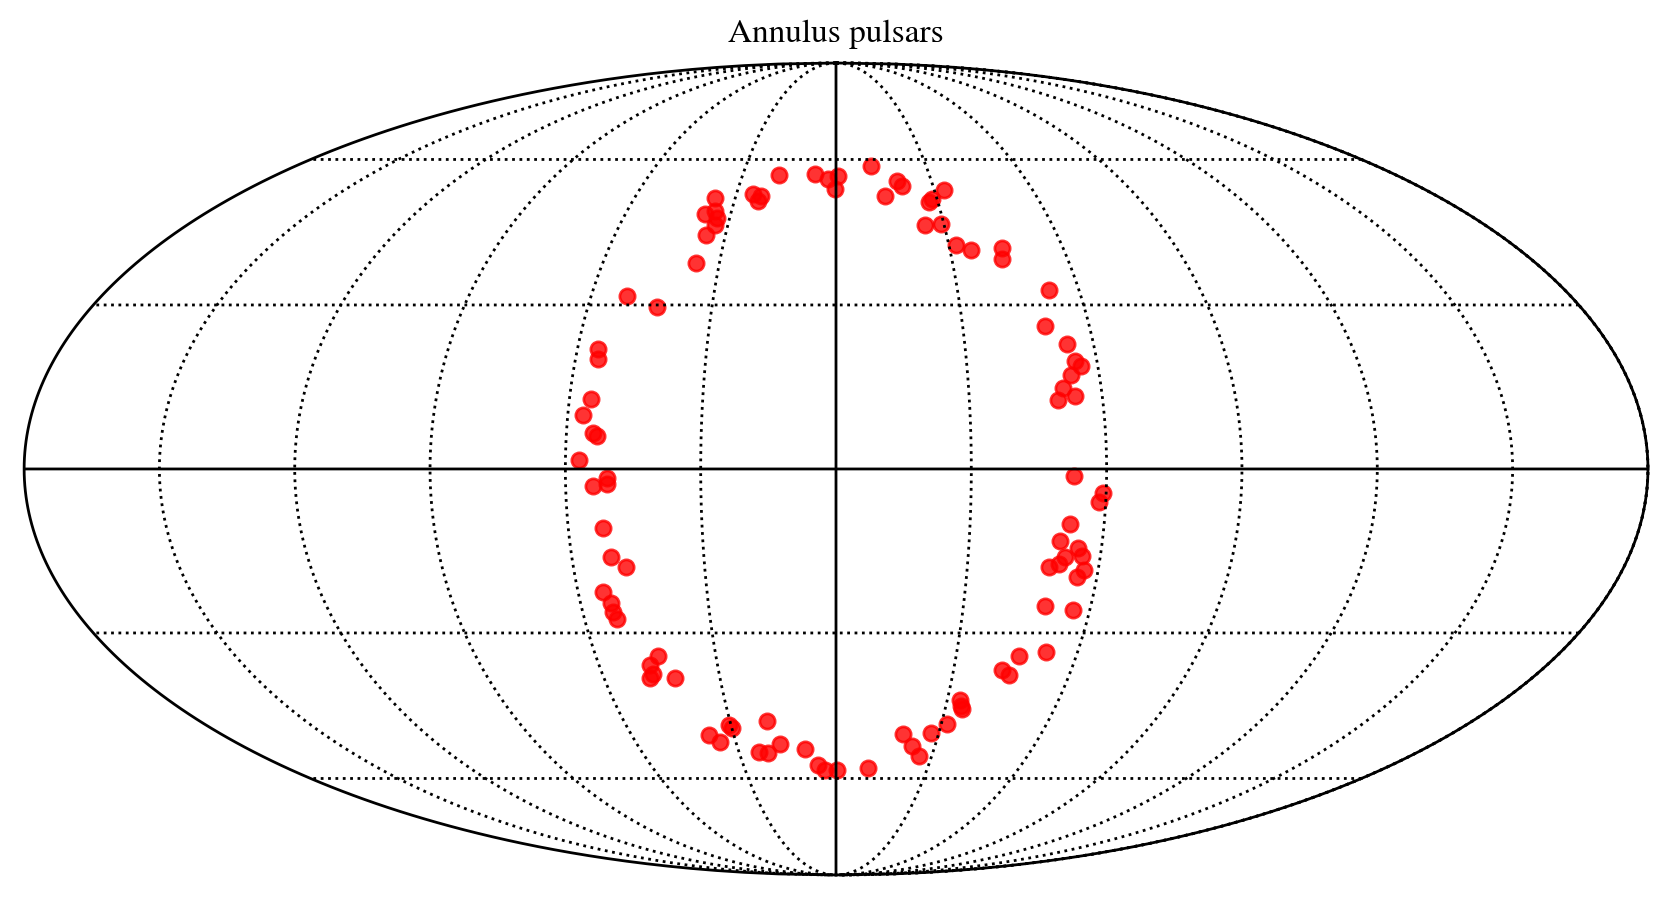

In [844]:
# overlay pulsar positions from the last psrs_annulus
# generate ring of pulsars (this must itself be jittable!)
# per-iteration seed from high‑res clock + loop index (avoid accidental duplicates)
seed = (time.time_ns()) & 0xffffffff
key = jax.random.PRNGKey(seed)
psrs_ann = utils.pulsar_annulus_generator(pars=pars, inner_ang_radius=50.0, width_deg=10.0,
                                           npsrs=100, toas=toas_new, toaerrs=toaerrs, key=key)
ras = np.degrees(np.array([p.ra for p in psrs_ann]))
decs = np.degrees(np.array([p.dec for p in psrs_ann]))

# create an empty background (or supply a map)
empty_map = np.zeros(hp.nside2npix(nside))
hp.mollview(empty_map, title='Annulus pulsars', cmap='Greys', min=0, max=1, cbar=False)
hp.projscatter(ras, decs, lonlat=True, s=30, color='red', marker='o', alpha=0.8)
hp.graticule()
plt.show()

### Expanding North Pole random cap of pulsars

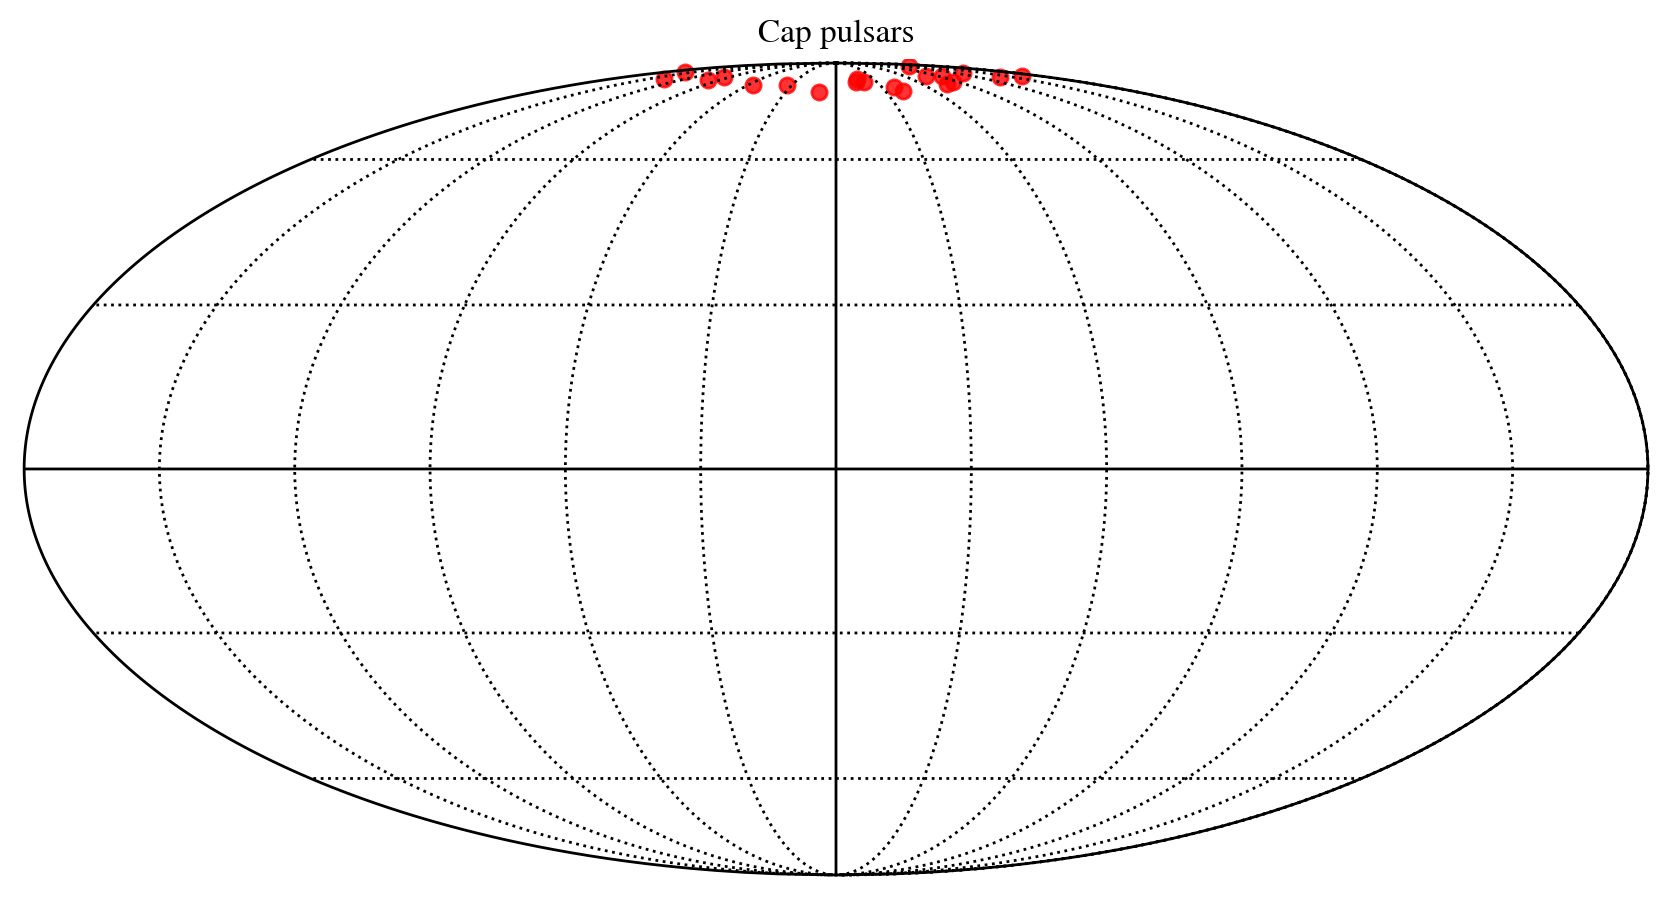

In [848]:
# overlay pulsar positions from the last psrs_annulus
# generate ring of pulsars (this must itself be jittable!)
# per-iteration seed from high‑res clock + loop index (avoid accidental duplicates)
seed = (time.time_ns()) & 0xffffffff
key = jax.random.PRNGKey(seed)

pars_copy = copy.deepcopy(pars)
pars_copy['cw_costheta'] = 0.999
psrs_cap = utils.pulsar_cap_generator(pars=pars_copy, ang_radius=10.0, npsrs=20,
                                       toas=toas_new, toaerrs=toaerrs, key=key)
ras = np.degrees(np.array([p.ra for p in psrs_cap]))
decs = np.degrees(np.array([p.dec for p in psrs_cap]))

# create an empty background (or supply a map)
empty_map = np.zeros(hp.nside2npix(nside))
hp.mollview(empty_map, title='Cap pulsars', cmap='Greys', min=0, max=1, cbar=False)
hp.projscatter(ras, decs, lonlat=True, s=30, color='red', marker='o', alpha=0.8)
hp.graticule()
plt.show()

In [853]:
from functools import partial

# 1) write a pure “per‐pixel” function
@partial(jax.jit, static_argnames=('npsrs','ang_radius'))
def _compute_pixel(theta, phi,
                   pars_base,
                   toas, toaerrs,
                   npsrs=20, ang_radius=10.0):
    # generate cap of pulsars (this must itself be jittable!)
    psrs = utils.pulsar_cap_generator(
        pars=pars_base,
        ang_radius=ang_radius,
        npsrs=npsrs,
        toas=toas,
        toaerrs=toaerrs,
    )

    # instantiate CW_Signals
    cws = [utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
           for p in psrs]

    # update sky location
    pars = pars_base.copy()
    pars['cw_costheta'] = jnp.cos(theta)
    pars['cw_phi']      = phi

    # total SNR
    snr2 = jnp.stack([utils.computer_snr2(cw, pars) for cw in cws])
    total_snr = jnp.sqrt(jnp.sum(snr2, axis=0))

    # renormalize distance
    pars['cw_log10_dist'] = jnp.log10(
        total_snr * 10**pars_base['cw_log10_dist'] / 10.0
    )

    # Fisher matrix sum
    fishers = jnp.stack([utils.compute_fisher(cw, pars) for cw in cws])
    F = jnp.sum(fishers, axis=0)

    # unmarginalized & marginalized areas
    ω = (180/jnp.pi)**2 * 2*jnp.pi / jnp.linalg.det(F[:2,:2])**0.5
    Finv = jnp.linalg.pinv(F)
    ω_marg = (180/jnp.pi)**2 * 2*jnp.pi * jnp.linalg.det(Finv[:2,:2])**0.5

    return total_snr, ω, ω_marg

# 2) vmap it over your Healpix arrays
snr_map, omega_map, omega_marg_map = jax.vmap(
    partial(_compute_pixel,
            pars_base=pars_map,
            toas=toas_new,
            toaerrs=toaerrs,
            npsrs=20,
            ang_radius=10.0),
    in_axes=(0,0)
)(theta_hp, phi_hp)

# now snr_map, omega_map, omega_marg_map are jax arrays of length npix

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:49: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)
/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:50: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.pdist = jnp.array(pdist)


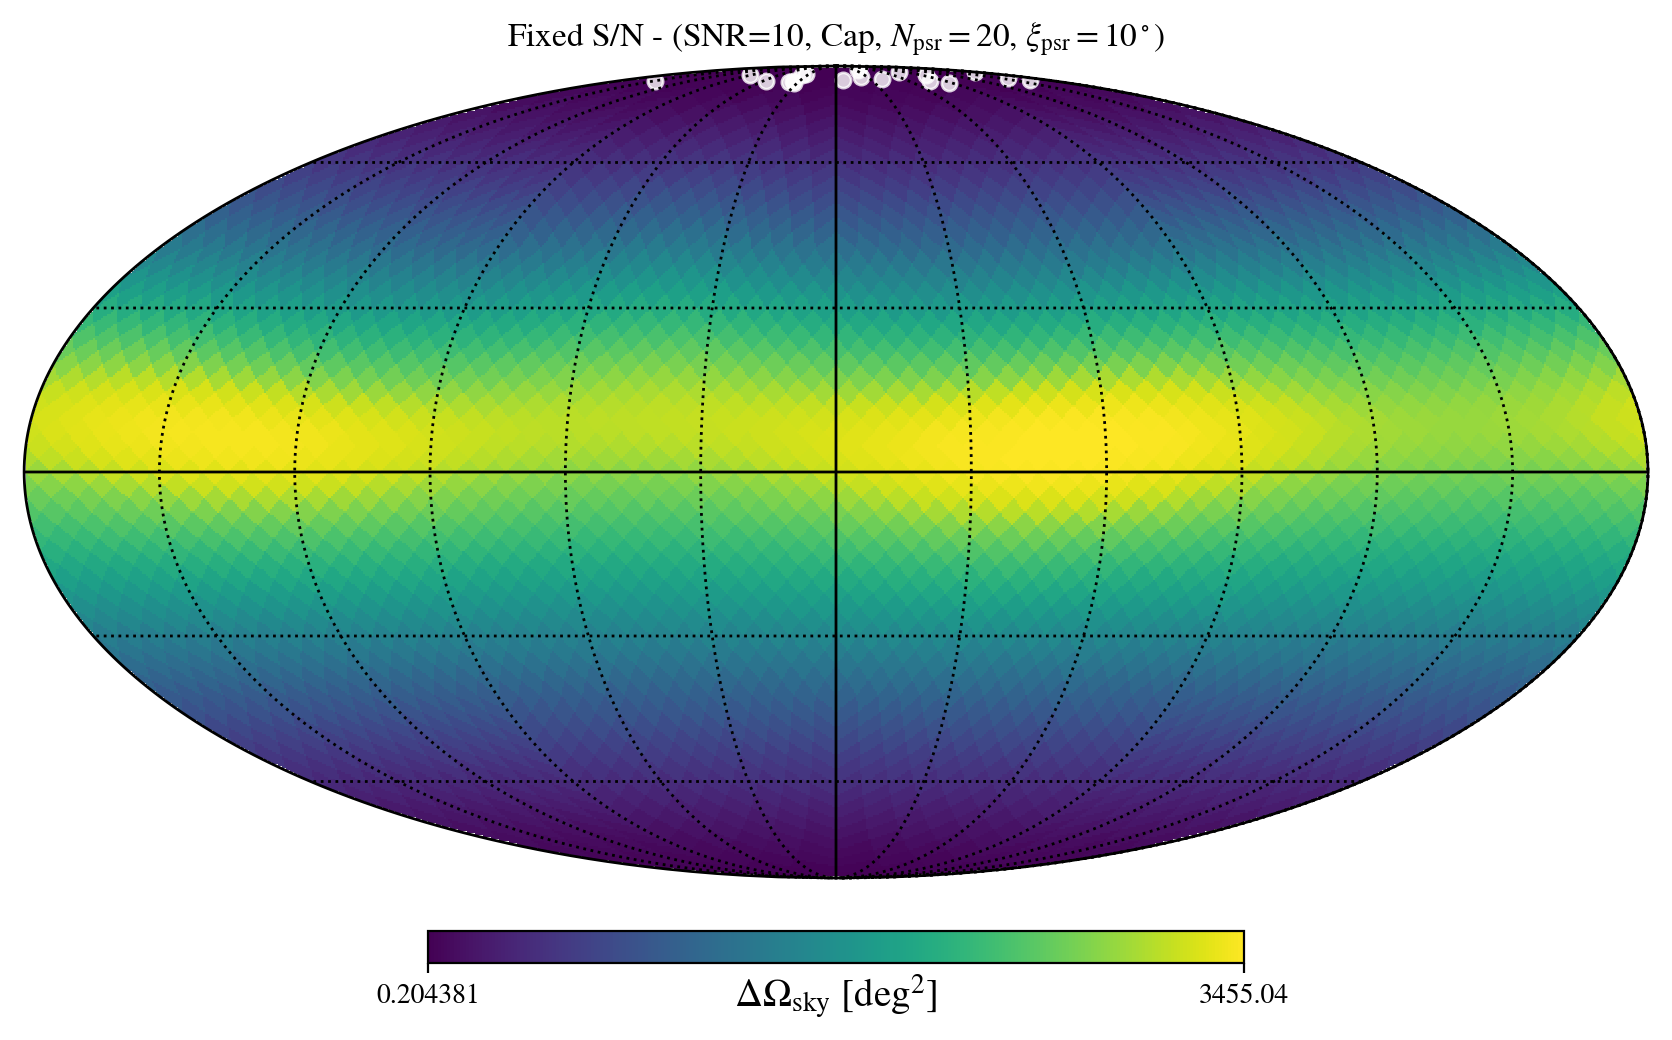

In [854]:
# Plot with a Mollweide projection
hp.mollview(omega_map,
            title=r'Fixed S/N - (SNR=10, Cap, $N_{\rm psr}=20$, $\xi_{\rm psr}=10^\circ)$',
            unit='$\Delta\Omega_{\\rm sky}$ [deg$^2$]',
            cmap='viridis',
            norm='hist')
# overlay pulsar positions from the last psrs_cap
# generate cap of pulsars (this must itself be jittable!)
psrs_cap = utils.pulsar_cap_generator(pars=pars_map, ang_radius=10.0, npsrs=20, 
                                        toas=toas_new, toaerrs=toaerrs)
ras = np.degrees(np.array([p.ra for p in psrs_cap]))
decs = np.degrees(np.array([p.dec for p in psrs_cap]))
hp.projscatter(ras, decs, lonlat=True, s=30, color='white', marker='o', alpha=0.8)
hp.graticule()
plt.show()

### Don't fix the SNR

In [19]:
angles = jnp.linspace(0.1,80.0,10)
omega_sky_vsnr = []
omega_sky_vsnr_marg = []
snrs = []

seed = int(time.time() * 1e6) % (2**31 - 1)
key = jax.random.PRNGKey(seed)

for ang in angles:
    key, subkey = jax.random.split(key)
    npsrs = int(jax.random.randint(subkey, (), 10, 51))
    print(npsrs)

    # deep-copy the dictionary so nested objects are also copied
    pars_copy = copy.deepcopy(pars)
    key, subkey2 = jax.random.split(key)
    key, subkey3 = jax.random.split(key)
    key, subkey4 = jax.random.split(key)
    key, subkey5 = jax.random.split(key)
    pars_copy['cw_log10_dist'] = jax.random.uniform(subkey2, minval=2.5, maxval=4.0)
    pars_copy['cw_cosinc'] = jax.random.uniform(subkey3, minval=-0.99, maxval=0.99)
    pars_copy['cw_psi'] = jax.random.uniform(subkey4, minval=0.01, maxval=jnp.pi-0.01)
    pars_copy['cw_phase0'] = jax.random.uniform(subkey5, minval=0.01, maxval=2.0*jnp.pi-0.01)

    psrs_ring = utils.pulsar_ring_generator(pars=pars_copy, ang_radius=ang, npsrs=npsrs, 
                                            toas=toas_new, toaerrs=toaerrs)
    # Instantiate a CW_Signal for each pulsar in the psrs list
    cw_signals = [
        utils.CW_Signal(psr=p, tref=p.toas[0], evolve=False)
        for p in psrs_ring
                ]
    
    # deep-copy the dictionary so nested objects are also copied
    #pars_copy = copy.deepcopy(pars)
    total_snr = jnp.sum(jnp.stack([utils.computer_snr2(cw,pars_copy) 
                                   for cw in cw_signals]), axis=0)**0.5
    snrs.append(total_snr)
    #snrs.append([utils.computer_snr2(cw,pars_copy) for cw in cw_signals])

    #pars_copy['cw_log10_dist'] = jnp.log10(total_snr * 10**pars['cw_log10_dist'] / 10.)
    # list of fisher matrices, one per pulsar
    fishers = [utils.compute_fisher(cw,pars_copy) for cw in cw_signals]
    total_fisher = jnp.sum(jnp.stack(fishers), axis=0)
    #modified_snr = jnp.sum(jnp.stack([computer_snr2(cw,pars_copy) for cw in cw_signals]), axis=0)**0.5
    #print(total_snr, modified_snr)
    
    fisher_inv = jnp.linalg.pinv(total_fisher)[:2,:2]
    omega_sky_vsnr_marg.append( (180/jnp.pi)**2 * 2.0*jnp.pi * jnp.linalg.det(fisher_inv)**0.5 )
    omega_sky_vsnr.append( (180/jnp.pi)**2 * 2.0*jnp.pi / jnp.linalg.det(total_fisher[:2,:2])**0.5 )

15
39
39
26
49
49
23
45
49
16


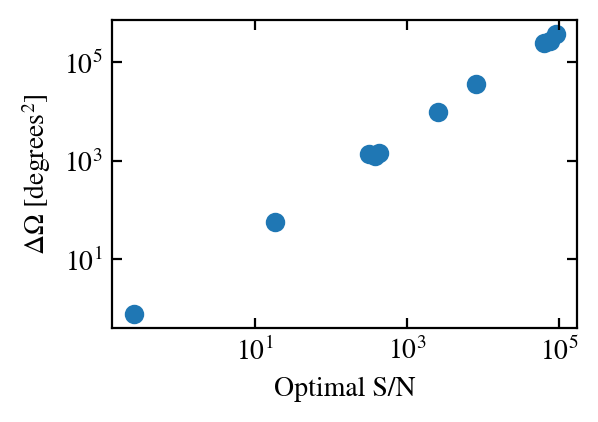

In [20]:
#plt.scatter(jnp.array(angles), 
#            jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.scatter(jnp.array(snrs), 
#            jnp.array(omega_sky_vsnr), label='SNR=10');

plt.scatter(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
            jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.scatter(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr_marg), label='SNR=10');
#plt.scatter(omega_wgtinterp(jnp.linspace(1.,70.,40)) / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.scatter(omega_wgtinterp(jnp.linspace(1.,70.,40)) / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr_marg), label='SNR=10');

#plt.plot(angles, jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.plot(angles, jnp.array(omega_sky_vsnr_marg), label='SNR=10');

#plt.scatter(jnp.array(snrs), omega_sky_vsnr, label='SNR=10');
#plt.plot(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
#         jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, label='$\propto \\theta_\mathrm{sep}^2$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('Optimal S/N')
plt.ylabel('$\Delta\Omega$ [degrees$^2$]')
plt.minorticks_on()
plt.tick_params(which='both',tick2On=True,direction='in')
#plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3, 2)

plt.show()

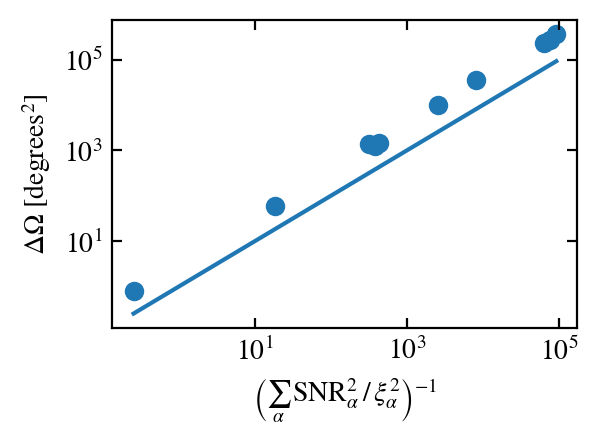

In [24]:
plt.scatter(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
            jnp.array(omega_sky_vsnr), label='SNR=10');
plt.plot(jnp.sort(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0), 
            jnp.sort(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0), label='SNR=10');
#plt.scatter(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr_marg), label='SNR=10');
#plt.scatter(omega_wgtinterp(jnp.linspace(1.,70.,40)) / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.scatter(omega_wgtinterp(jnp.linspace(1.,70.,40)) / jnp.array(snrs)**2.0, 
#            jnp.array(omega_sky_vsnr_marg), label='SNR=10');

#plt.plot(angles, jnp.array(omega_sky_vsnr), label='SNR=10');
#plt.plot(angles, jnp.array(omega_sky_vsnr_marg), label='SNR=10');

#plt.scatter(jnp.array(snrs), omega_sky_vsnr, label='SNR=10');
#plt.plot(jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, 
#         jnp.array(angles)**2.0 / jnp.array(snrs)**2.0, label='$\propto \\theta_\mathrm{sep}^2$')

plt.xscale('log')
plt.yscale('log')
plt.xlabel('$\left(\\sum_\\alpha\, \mathrm{SNR}_\\alpha^2 \,/\, \\xi_\\alpha^2\\right)^{-1}$')
plt.ylabel('$\Delta\Omega$ [degrees$^2$]')
plt.minorticks_on()
plt.tick_params(which='both',tick2On=True,direction='in')
#plt.legend()

fig = matplotlib.pyplot.gcf()
fig.set_size_inches(3, 2)

plt.show()

### Analytic average over phase, polarization, and inclination

If 1 pulsar, will keep at RA of pulsar and move DEC.

In [810]:
pars

{'cw_costheta': 0.0,
 'cw_phi': 0.0,
 'cw_cosinc': 0.99,
 'cw_log10_Mc': 9.5,
 'cw_log10_fgw': -8.0,
 'cw_log10_dist': 2.385,
 'cw_phase0': 0.0,
 'cw_psi': 0.0}

In [818]:
pars_copy = copy.deepcopy(pars)
pars_copy['cw_costheta'] = 0.0 #jnp.cos(0.000001) #0.999
pars_copy['cw_phi'] = 0.0 #jnp.pi

In [819]:
pars_copy

{'cw_costheta': 0.0,
 'cw_phi': 0.0,
 'cw_cosinc': 0.99,
 'cw_log10_Mc': 9.5,
 'cw_log10_fgw': -8.0,
 'cw_log10_dist': 2.385,
 'cw_phase0': 0.0,
 'cw_psi': 0.0}

In [820]:
angles = jnp.linspace(0.1,179.9,100)
#omega_sky_vsnr = []
#snrs = []

#seed = int(time.time() * 1e6) % (2**31 - 1)
#key = jax.random.PRNGKey(seed)

total_fisher_weight_sum = []
tmp1_sum = []
tmp2_sum = []
for ang in angles:

    psrs_ring = utils.pulsar_ring_generator(pars=pars_copy, ang_radius=ang, npsrs=20, 
                                            toas=toas_new, toaerrs=toaerrs)
    
    tmp1, tmp2, fisher_weight_sum = [], [], []
    for p in psrs_ring:
        
        param_vec = jnp.array([pars_copy['cw_costheta'], pars_copy['cw_phi']])
        
        def fp_func(vec):
            fplus, _, _ = utils.create_gw_antenna_pattern(p._pos, 
                                                           #vec[0],
                                                           jnp.arccos(vec[0]), 
                                                           vec[1])
            return fplus
        def fc_func(vec):
            _, fcross, _ = utils.create_gw_antenna_pattern(p._pos, 
                                                           #vec[0],
                                                           jnp.arccos(vec[0]), 
                                                           vec[1])
            return fcross
        
        # Jacobian: shape (n_params, n_toas)
        fp_jac = jax.jacrev(fp_func)(param_vec)
        fc_jac = jax.jacrev(fc_func)(param_vec)
        #print(fp_jac.shape, fc_jac.shape, fp_func(param_vec), fc_func(param_vec))
        
        # “test” matrix and Fisher
        tmp1.append(jnp.outer(fp_jac, fp_jac) + jnp.outer(fc_jac, fc_jac))
        tmp2.append(fp_func(param_vec)**2 + fc_func(param_vec)**2)
        fisher_weight = jnp.outer(fp_jac, fp_jac) + jnp.outer(fc_jac, fc_jac)
        
        #print(-0.5*(1.0+jnp.cos(jnp.pi/2.0 - p.dec)), fp_func(param_vec), fp_jac, fc_func(param_vec), fc_jac)
        fisher_weight /= (fp_func(param_vec)**2 + fc_func(param_vec)**2)
        #print((fp_func(param_vec)**2 + fc_func(param_vec)**2))
        fisher_weight_sum.append(fisher_weight)

    #print(jnp.degrees(jnp.arccos(utils.create_gw_antenna_pattern(psrs_ring[0]._pos, 
    #                                                 jnp.arccos(pars['cw_costheta']), 
    #                                                 pars['cw_phi'])[2])), ang)
    tmp1_sum.append(jnp.sum(jnp.stack(tmp1), axis=0))
    tmp2_sum.append(jnp.sum(jnp.stack(tmp2), axis=0))
    total_fisher_weight_sum.append(jnp.sum(jnp.stack(fisher_weight_sum), axis=0))

    
    #fisher_inv = jnp.linalg.pinv(total_fisher)[:2,:2]
    #omega_sky_vsnr.append( (180/jnp.pi)**2 * 2.0*jnp.pi * jnp.linalg.det(fisher_inv)**0.5 )

/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:49: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.design_matrix = jnp.array(design_matrix)
/Users/taylosr8/Research/repos/pta_cw_fisher/utils.py:50: FutureWarning: None encountered in jnp.array(); this is currently treated as NaN. In the future this will result in an error.
  self.pdist = jnp.array(pdist)


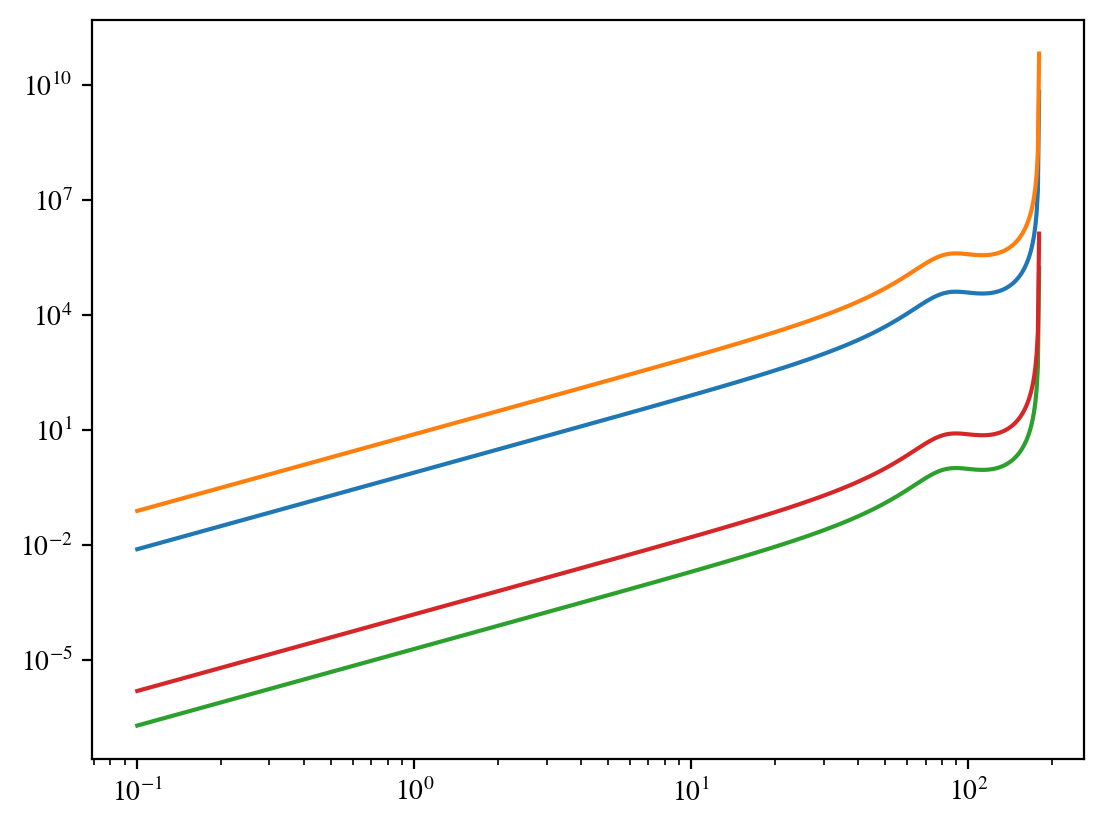

In [ ]:
# numerical fisher
plt.loglog(angles[:100], 1e5/jnp.array(tmp1_sum)[:100,0,0]);
plt.loglog(angles[:100], 1e6/jnp.array(tmp1_sum)[:100,1,1]);

# analytic fisher
plt.loglog(angles, (1-jnp.cos(jnp.radians(angles)))**4.0 / (
    2*(1-jnp.cos(jnp.radians(angles)))**2.0 * jnp.sin(jnp.radians(2*angles))**2.0
       + jnp.sin(jnp.radians(angles))**6.0 
       - 2*(1-jnp.cos(jnp.radians(angles))) * jnp.sin(jnp.radians(angles))**3.0 * jnp.sin(jnp.radians(2*angles)))
);
plt.loglog(angles, 1/((5*jnp.cos(angr)**2 - 2*jnp.cos(angr) + 1) / 8 / jnp.tan(angr/2)**2));

plt.show()

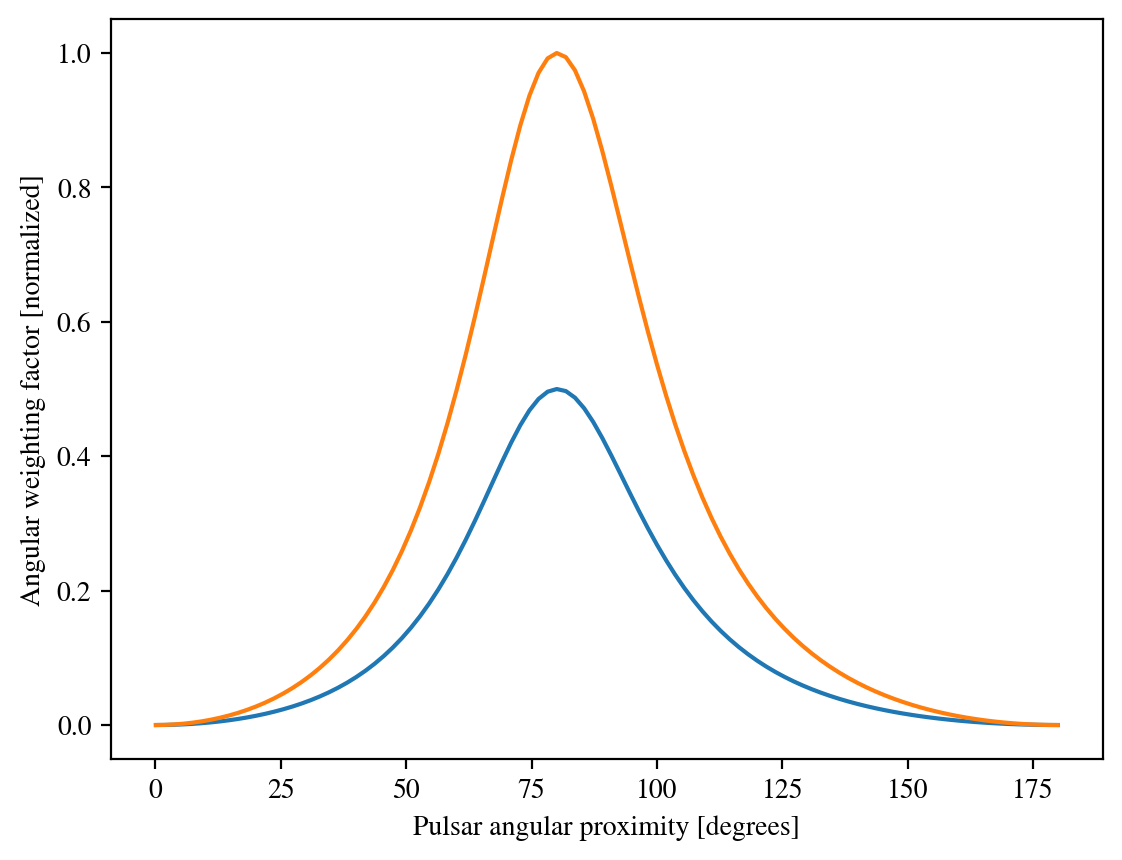

In [ ]:
# analytic calculation with rotations about m and n vectors
angr = jnp.radians(angles)
#X = ( 0.5*jnp.sin(angr)**6 - 1.0*jnp.sin(angr)**3 * jnp.sin(2*angr) * (1 - jnp.cos(angr)) 
#     + 1.0*jnp.sin(2*angr)**2 * (1 - jnp.cos(angr))**2
#     ) / 4 / (1- jnp.cos(angr))**4
X = (5*jnp.cos(angr)**2 - 2*jnp.cos(angr) + 1) / 8 / jnp.tan(angr/2)**2
Y = 0.25 * (1 + jnp.cos(angr))**2
plt.plot(angles, 0.5 * (Y/X)/((Y/X).max()));

# true numerical calculation
wgt_tmp = [1.0/jnp.linalg.det(ttfws)**0.5 for ttfws in jnp.array(total_fisher_weight_sum)]
plt.plot(angles, wgt_tmp/np.max(wgt_tmp));

plt.ylabel('Angular weighting factor [normalized]')
plt.xlabel('Pulsar angular proximity [degrees]')
plt.show()

In [68]:
# compute ω(θ) on your existing grid once
omega_weights = jnp.array([1.0/jnp.linalg.det(w)**0.5 for w in total_fisher_weight_sum])

# define an interpolant function
def omega_wgtinterp(theta):
    """
    interpolate sky‐localization area ω as a function of pulsar‐separation angle θ
    supports both scalars and array inputs
    """
    return jnp.interp(theta, angles, omega_weights)

# example usage:
print(omega_wgtinterp(20.0))             # scalar input
print(omega_wgtinterp(jnp.linspace(1,179,5)))  # vector input

0.002119516629781016
[5.07747252e-06 1.28196931e-02 3.48036597e-02 6.17423523e-03
 4.61207379e-06]


In [72]:
# Convert JAX arrays to NumPy arrays for saving
angles_np = np.array(angles)
omega_weights_np = np.array(omega_weights)

# Save the arrays to a compressed .npz file
np.savez('omega_interpolation_data.npz', angles=angles_np, omega_weights=omega_weights_np)

print("Interpolation data saved to omega_interpolation_data.npz")

Interpolation data saved to omega_interpolation_data.npz


### Other little tests

#### Trying some tests with sympy

In [281]:
import sympy as sp

# 1) declare symbols
alphap, betap, gwtheta, gwphi = sp.symbols('alphap betap gwtheta gwphi', real=True)

# 2) build vectors
pos    = sp.Matrix([sp.sin(alphap)*sp.cos(betap),
                    sp.sin(alphap)*sp.sin(betap),
                    sp.cos(alphap)])
m      = sp.Matrix([sp.sin(gwphi), -sp.cos(gwphi), 0])
n      = sp.Matrix([
    -sp.cos(gwtheta)*sp.cos(gwphi),
    -sp.cos(gwtheta)*sp.sin(gwphi),
     sp.sin(gwtheta)
])
omhat  = sp.Matrix([
    -sp.sin(gwtheta)*sp.cos(gwphi),
    -sp.sin(gwtheta)*sp.sin(gwphi),
    -sp.cos(gwtheta)
])

# 3) dot‐products
mp    = m.dot(pos)
np_   = n.dot(pos)
omp   = omhat.dot(pos)

# 4) antenna‐pattern expressions
fplus_sym  = sp.simplify(0.5*(mp**2 - np_**2)/(1 + omp))
fcross_sym = sp.simplify(mp*np_/(1 + omp))
cosMu_sym  = sp.simplify(-omp)

Frep = sp.simplify(fplus_sym + 1j*fcross_sym)

# 5) inspect or simplify further
fplus_sym, fcross_sym, cosMu_sym

(0.5*((sin(alphap)*cos(gwtheta)*cos(betap - gwphi) - sin(gwtheta)*cos(alphap))**2 - sin(alphap)**2*sin(betap - gwphi)**2)/(sin(alphap)*sin(gwtheta)*cos(betap - gwphi) + cos(alphap)*cos(gwtheta) - 1),
 -(sin(alphap)*cos(gwtheta)*cos(betap - gwphi) - sin(gwtheta)*cos(alphap))*sin(alphap)*sin(betap - gwphi)/(sin(alphap)*sin(gwtheta)*cos(betap - gwphi) + cos(alphap)*cos(gwtheta) - 1),
 sin(alphap)*sin(gwtheta)*cos(betap - gwphi) + cos(alphap)*cos(gwtheta))

In [282]:
Frep2 = sp.simplify(Frep.subs(gwtheta, 0))

In [292]:
# 4) Differentiate wrt your parameters [cw_costheta, cw_phi]
dfrep = sp.simplify(sp.Matrix([sp.diff(Frep2, v)  for v in (alphap, betap)]))
#dfp = sp.simplify(sp.Matrix([sp.diff(Frep2, v)  for v in (alphap, betap)]))
#dfc = sp.simplify(sp.Matrix([sp.diff(Frep2, v) for v in (alphap, betap)]))

fisher_sym = sp.re(sp.simplify(dfrep*sp.conjugate(dfrep).T / (Frep2*sp.conjugate(Frep2))))
fisher_sym = fisher_sym.as_mutable()
fisher_sym[0,0] /= sp.sin(alphap)**2
sp.simplify(fisher_sym.det()**0.5)
# 5) Build the Fisher‐weight matrix
#F = sp.Matrix(dfp)*sp.Matrix(dfp).T + sp.Matrix(dfc)*sp.Matrix(dfc).T

# 6) Simplify or inspect
#sp.simplify(F)

4.0*(1/((cos(alphap) - 1)**2*sin(alphap)**4))**0.5*Abs(0.5*sin(alphap)**2 + 1.0*cos(alphap) - 1.0)**1.0

#### Attempt at symbolic regression

In [ ]:
!pip install pysr

In [51]:
from pysr import PySRRegressor

model = PySRRegressor(
    maxsize=50,
    niterations=40,  # < Increase me for better results
    binary_operators=["+", "-", "*", "/"],
    unary_operators=[
        "cos",
        "sin",
        # ^ Custom operator (julia syntax)
    ],
    extra_sympy_mappings={"inv": lambda x: 1 / x},
    # ^ Define operator for SymPy as well
    elementwise_loss="loss(prediction, target) = (prediction - target)^2",
    # ^ Custom loss function (julia syntax)
)

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 4095: unexpected end of data

In [52]:
model.fit(jnp.radians(angles).reshape(-1, 1), wgt_tmp/np.max(wgt_tmp))

/Users/taylosr8/miniconda3/envs/pandora/lib/python3.11/site-packages/pysr/sr.py:1469: UserWarning: Note: Using a large maxsize for the equation search will be exponentially slower and use significant memory.
  warnings.warn(
/Users/taylosr8/miniconda3/envs/pandora/lib/python3.11/site-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!
[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.3373795   
	1         0.097975                                       sin(sin(x0))   
	2         1.040129                              sin(x0) + -0.29675803   
	3         0.110720                          cos(cos(x0) * -1.7053518)   
	4         0.353502                       cos(sin(cos(x0)) * 1.957886)   
	5         0.492928               cos(cos(x0 * -1.1622853) * 1.656854)   
	6         1.082284         cos(sin(cos(x0 * 1.1166762)) * -1.9098833)   
	7         0.950130    cos(sin(sin(cos(x0 * 1.1109457))) * -2.1178124)   
	8         0.304742  cos(sin(sin(cos(x0 * 1.1069206))) * -2.1029856...   
	9         0.334804  cos(sin(sin(cos(-0.15135932 - x0) * 1.3528844)...   
	10        1.048492  cos(sin(sin(cos(-0.19514275 - x0) * 1.3897133)...   
	11        0.084971  (sin(x0) * cos(sin(sin(cos(x0 - -0.19470516) *...   
	12        0.000001  (cos(sin(sin(cos(x0 - -0.19470516) * 1.4075551...   
	13        0.011579  (cos(sin(sin(cos(x0 - -0.19470516) * 1.4075551...   
	14        0.011130  (x0 * ((sin(x0) * cos(sin(sin(cos(-0.19741504 ...   
	15        0.084855  (cos(sin(sin(cos(x0 - -0.19615704) * 1.4269356...   
	16        0.014774  (sin(sin(x0 + (-0.061134074 + sin(x0)))) * sin...   
	17        0.110189  sin(x0) * (((cos(-1.0309614 - cos(x0)) * (sin(...   
	18        1.037163  (sin(x0) * sin(sin(sin(x0) + (x0 + -0.04478535...   
	19        0.028422  (sin(sin(sin(x0) + (x0 + -0.045113895))) * ((x...   
	20        0.058605  (sin(sin((-0.046460837 + sin(x0)) + x0)) * ((s...   
	21        0.014959  (((sin(x0) * x0) + (((sin(x0 * 4.0111666) * -0...   
	22        0.364971  sin(x0) * (sin(sin((x0 + sin(x0)) + -0.0469767...   
	23        0.006749  (sin(sin((x0 + sin(x0)) + -0.046979036)) * sin...   
	24        0.006803  sin(x0) * (((((sin(x0 * 4.0018334) * -0.450263...   
	25  >>>>  0.372997  (sin(sin(x0 + (sin(x0) + -0.048540864))) * sin...   
	26        0.070925  sin(x0) * (sin(sin((x0 + -0.047610313) + sin(x...   
	27        0.071875  (sin(x0) * (sin(sin((x0 + sin(x0)) + -0.046573...   
	
	        loss  complexity  
	0   0.108665           1  
	1   0.089328           3  
	2   0.031569           4  
	3   0.028261           5  
	4   0.019845           6  
	5   0.012122           7  
	6   0.004107           8  
	7   0.001588           9  
	8   0.000863          11  
	9   0.000442          13  
	10  0.000155          14  
	11  0.000131          16  
	12  0.000131          17  
	13  0.000129          18  
	14  0.000126          20  
	15  0.000107          22  
	16  0.000096          29  
	17  0.000086          30  
	18  0.000031          31  
	19  0.000026          36  
	20  0.000022          39  
	21  0.000022          40  
	22  0.000015          41  
	23  0.000015          42  
	24  0.000015          43  
	25  0.000010          44  
	26  0.000009          46  
	27  0.000008          48  
]

Error in callback _flush_stdio (for post_execute), with arguments args (),kwargs {}:


UnicodeDecodeError: 'utf-8' codec can't decode byte 0xe2 in position 4095: unexpected end of data

In [35]:
print(model)

PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                          0.3373795   
	1         0.097975                                       sin(sin(x0))   
	2         1.040129                               sin(x0) + -0.2967584   
	3         0.110720                           cos(cos(x0) * 1.7053564)   
	4         0.353502                     cos(sin(cos(x0)) * -1.9578754)   
	5         0.624845              cos(cos(x0 / -0.8874614) / -0.605487)   
	6         0.950367         cos(sin(cos(x0 * -1.1166651)) * 1.9098456)   
	7         0.000736    sin(cos(sin(cos(x0 / 0.9005047)) * -1.8977151))   
	8         0.641525  cos(sin(cos(x0 / 0.90101165)) * -1.777212) + -...   
	9         0.744370  (cos(cos(x0 + 0.15042672) / -0.3118234) * 0.45...   
	10        0.280428  cos(cos(x0) / 0.6369252) * cos(cos(x0 / 0.7979...   
	11        0.584249  cos(1.7616117 * (cos(0.16639592 + x0) / (cos(c...   
	12  >>>>

### Sanity checks and diff tests

In [56]:
param_vec = jnp.array([0.0, 0.0])
test_omega_var = []
test_seps = []
for alpha in jnp.radians(jnp.linspace(0.0, 50.0, 10)):
    #alpha = jnp.radians(10.0)  # Example angle for pulsar position
    test_pulsar_position = jnp.array([jnp.cos(alpha), 0.0, jnp.sin(alpha)])  # Example pulsar position
    origin = jnp.array([jnp.sin(jnp.arccos(param_vec[0])) * jnp.cos(param_vec[1]),
                       jnp.sin(jnp.arccos(param_vec[0])) * jnp.sin(param_vec[1]),
                       jnp.cos(jnp.arccos(param_vec[0]))])
    #print(test_pulsar_position, origin)
    # rebuild delays function
    def fp_func(vec):
        fplus, _, _ = utils.create_gw_antenna_pattern(test_pulsar_position, 
                                                        jnp.arccos(vec[0]), 
                                                        vec[1])
        return fplus
    def fc_func(vec):
        _, fcross, _ = utils.create_gw_antenna_pattern(test_pulsar_position, 
                                                        jnp.arccos(vec[0]), 
                                                        vec[1])
        return fcross
    # Jacobian: shape (n_params, n_toas)
    fp_jac = jax.jacrev(fp_func)(param_vec)
    fc_jac = jax.jacrev(fc_func)(param_vec)
    # “test” matrix and Fisher
    fisher_weight = jnp.outer(fp_jac, fp_jac) + jnp.outer(fc_jac, fc_jac)
    fisher_weight /= (fp_func(param_vec)**2 + fc_func(param_vec)**2)
    cosMu = utils.create_gw_antenna_pattern(test_pulsar_position, 
                                            jnp.arccos(param_vec[0]), 
                                            param_vec[1])[2]
    #test_omega_var.append(1.0/jnp.linalg.det(fisher_weight)**0.5)
    test_omega_var.append(fisher_weight)
    test_seps.append(jnp.degrees(jnp.arccos(cosMu)))
    print(jnp.degrees(jnp.arccos(cosMu)))

0.0
5.55555555555555
11.111111111111107
16.666666666666664
22.222222222222214
27.77777777777777
33.33333333333333
38.888888888888886
44.44444444444444
49.99999999999999


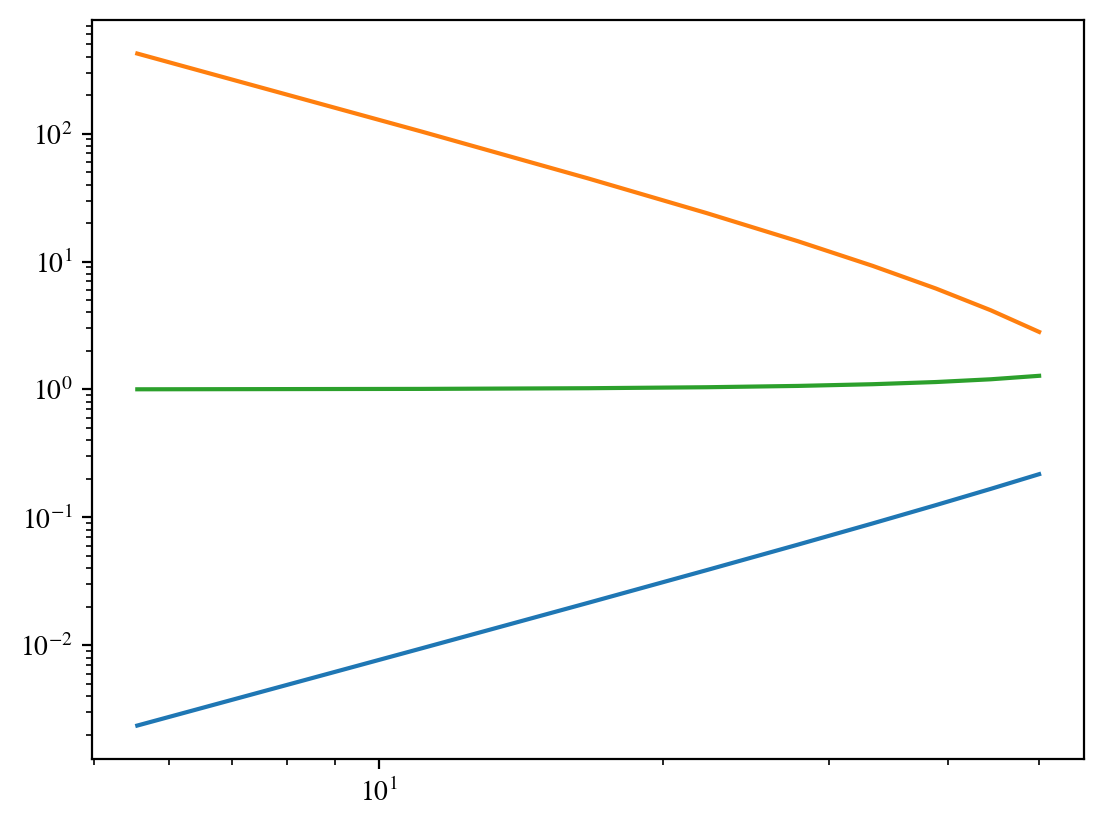

In [57]:
plt.loglog(test_seps, jnp.array(test_omega_var)[:,0,0], label='Test Omega Variance');
plt.loglog(test_seps, jnp.array(test_omega_var)[:,1,1], label='Test Omega Variance');
plt.loglog(test_seps, [1.0/jnp.linalg.det(ttfws)**0.5 for ttfws in test_omega_var], label='Test Omega Variance');
#plt.loglog(test_seps, 2/(1.0+jnp.cos(jnp.radians(test_sep_angles))), label='Test Omega Variance');
plt.show()

#### JAX differentiation tests

In [11]:
psrs_one = utils.pulsar_ring_generator(pars=pars, ang_radius=40.0, npsrs=1, 
                                            toas=toas_new, toaerrs=toaerrs)

def fp_func(costheta):
    fplus, _, _ = utils.create_gw_antenna_pattern(psrs_one[0]._pos, 
                                                    jnp.arccos(costheta), 
                                                    0.0)
    return fplus

In [12]:
jnp.diff(jnp.array([fp_func(ctheta) for ctheta in jnp.linspace(-1.0e-5, 1.0e-5, 10)])) / jnp.diff(jnp.linspace(-1.0e-5, 1.0e-5, 10))

Array([-0.32521133, -0.32521049, -0.32520964, -0.3252088 , -0.32520796,
       -0.32520711, -0.32520627, -0.32520542, -0.32520458], dtype=float64)

Confirmed that finite difference also agrees with JAX.